In [50]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.metrics.pairwise import euclidean_distances
from scipy.cluster.hierarchy import linkage, dendrogram

from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE
from scipy.spatial.distance import cdist
import itertools
from collections import Counter

from yellowbrick.cluster import KElbowVisualizer


from tqdm import tqdm

In [4]:
data = pd.read_csv('data.csv')

<h1>Задание</h1>
<b>Задача:</b>
<ol>
<li>Изучите датасэт, обработайте отрицательные продажи, обработайте специальные строки, которые не являются товарами и т.д.</li>
<li>Построить матрицу (A) чеки-товары, чтобы на пересечении оказалось число товаров (Quantity). Построить матрицу (B) чеки-товары, чтобы на пересечении оказалось число 1 - если была покупка, 0 - иначе.</li>
<li>Получите эмбединги товаров по матрицам А и B.
Для этого можно использовать SVD и NMF/NNMF c разным числом компанент (до 15). Оцените качество разложений. Выберите лучшее разложение для варианта А и B.</li>
    <li>Сделайте кластеризацию в полученом пространстве в лучших эмбедингах А и B. Для этого можно использовать любые алгоритмы кластеризации. Кол-во кластеров от 10 до 30. Но так, что в каждом кластере было не меньше 4000 чеков (т.е. продаж без учета Quantity). Выберите оптимальное разбиение. Обоснуйте решение.</li>
    <li>К лучшим эмбедингам А и B добавьте цену (UnitPrice) каждого товара. Будем называть такие эмбединги А', B'.</li> 
     <li>Сделайте кластеризицаю в полученном пространстве эмбедингов А' и B'. И решите задачу кластеризации. Кол-во кластеров взять оптимальным из 4-го пункта. Но! Нужно учесть, что компонент цены и остальная часть эмбединга находятся в разных "пространствах". Разрешите эту проблему с помощью метрики и/или изменением пространства.</li>
    <li>Найти товары заменители (на которые есть общий спрос). Объедините их в отдельные кластера.</li>
    <li>Найти товары "якоря" и сопутсвующие к ним. Объединить их в отдельные кластера. Мы не знаем порядок добавления товаров в чек, но полагаем что "якоря" покупают значительно чаще остальных.</li>
</ol>
<b>Анализ:</b>
<ul>
<li>
Оцените качество кластеризации. Выборочно посмотрите кластеры и сопоставьте по описанию (Description), опишите полученное качество. Сравните кластеризацию из пунктов 4 и 6.</li>
    <li>Есть ли товары, которые оказались в разных кластерах в пункте 4 (6), при этом оказались общими по спросу. Объясните этот эффект.</li>
<li>Выборочно посмотрите "якоря". Оцените качество кластеризации.</li>
<li>Какие проблемы могут быть при использовании такой кластеризации для задач динамического ценообразования?</li>
    </ul>

# 1. Препроцессинг/Анализ данных

In [ ]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
data.shape

(541909, 8)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [ ]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,531285.000000,531285.000000,397924.000000
mean,10.655262,3.857296,15294.315171
std,156.830323,41.810047,1713.169877
min,1.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13969.000000
50%,3.000000,2.080000,15159.000000
75%,10.000000,4.130000,16795.000000
max,80995.000000,13541.330000,18287.000000


## Отрицательные продажи

In [ ]:
data[data.Quantity<0].shape[0] / data.shape[0] * 100

1.9604767590130447

In [ ]:
data_negative = data[data.Quantity<=0]

Отрицательные продажи - это возврат товара, InvoiceNo начинается с C

In [ ]:
data_negative[data_negative.InvoiceNo.str.startswith('C')].shape[0] / data_negative.shape[0] * 100

87.42469879518072

In [ ]:
data_negative[(~data_negative.InvoiceNo.str.startswith('C')) & (data_negative.Quantity<0)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
2406,536589,21777,NaN,-10,12/1/2010 16:50,0.0,NaN,United Kingdom
4347,536764,84952C,NaN,-38,12/2/2010 14:42,0.0,NaN,United Kingdom
7188,536996,22712,NaN,-20,12/3/2010 15:30,0.0,NaN,United Kingdom
7189,536997,22028,NaN,-20,12/3/2010 15:30,0.0,NaN,United Kingdom
7190,536998,85067,NaN,-6,12/3/2010 15:30,0.0,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
535333,581210,23395,check,-26,12/7/2011 18:36,0.0,NaN,United Kingdom
535335,581212,22578,lost,-1050,12/7/2011 18:38,0.0,NaN,United Kingdom
535336,581213,22576,check,-30,12/7/2011 18:38,0.0,NaN,United Kingdom
536908,581226,23090,missing,-338,12/8/2011 9:56,0.0,NaN,United Kingdom


Но есть какие-то и исключения. Видимо, ошибки в InvoiceNo	

Кажется, что ~2% с отрицательными продажами можно просто удалить, много данных мы не потеряем.

In [5]:
data = data[data.Quantity>0]

## StockCode

In [ ]:
vc1 = data.StockCode.value_counts()

In [ ]:
t = pd.DataFrame(vc1)

array([[<AxesSubplot:title={'center':'StockCode'}>]], dtype=object)

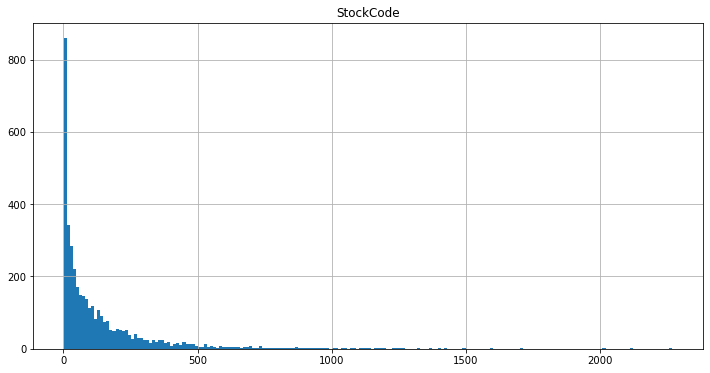

In [ ]:
t.hist(bins=200, figsize=(12,6))

In [ ]:
data[data.StockCode=='21984']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1273,536532,21984,PACK OF 12 PINK PAISLEY TISSUES,48,12/1/2010 13:24,0.29,12433.0,Norway
2630,536592,21984,PACK OF 12 PINK PAISLEY TISSUES,1,12/1/2010 17:06,0.85,NaN,United Kingdom
4640,536796,21984,PACK OF 12 PINK PAISLEY TISSUES,1,12/2/2010 15:46,0.29,15574.0,United Kingdom
6343,536876,21984,PACK OF 12 PINK PAISLEY TISSUES,2,12/3/2010 11:36,0.85,NaN,United Kingdom
9713,537212,21984,PACK OF 12 PINK PAISLEY TISSUES,24,12/5/2010 15:21,0.29,12720.0,Germany
...,...,...,...,...,...,...,...,...
538329,581405,21984,PACK OF 12 PINK PAISLEY TISSUES,3,12/8/2011 13:50,0.39,13521.0,United Kingdom
538363,581405,21984,PACK OF 12 PINK PAISLEY TISSUES,1,12/8/2011 13:50,0.39,13521.0,United Kingdom
539502,581439,21984,PACK OF 12 PINK PAISLEY TISSUES,1,12/8/2011 16:30,0.83,NaN,United Kingdom
539982,581453,21984,PACK OF 12 PINK PAISLEY TISSUES,24,12/8/2011 18:15,0.39,16401.0,United Kingdom


StockCode должен быть 5-значным номером. Посмотрим, везде ли это так

In [ ]:
data.shape

(531285, 8)

In [ ]:
data[(data.StockCode.str.isdigit()) & (data.StockCode.str.len() == 5)].shape

(478049, 8)

Возьмем только с корректным номером

In [ ]:
data = data[(data.StockCode.str.isdigit()) & (data.StockCode.str.len() == 5)]

# 2. Построение матрицы

In [28]:
data.shape

(531285, 8)

In [29]:
A = pd.pivot_table(data, values='Quantity', index=['InvoiceNo'], columns=['StockCode'])

In [30]:
A.fillna(0, inplace=True)

In [31]:
A = A.reset_index()

In [32]:
A.columns.name = None
A.index.name = None
A.drop(['InvoiceNo'], axis=1, inplace=True)

In [33]:
A.head()

,10002,10080,10120,10123C,10124A,10124G,10125,10133,10135,11001,...,M,PADS,POST,S,gift_0001_10,gift_0001_20,gift_0001_30,gift_0001_40,gift_0001_50,m
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
X_A = A.to_numpy()

In [35]:
X_A.shape

(20728, 3941)

In [36]:
B = (A > 0).astype(int)

In [37]:
X_B = B.to_numpy()

## Степень разреженности

In [38]:
sum(sum(X_B)) / (X_B.shape[0]*X_B.shape[1]) * 100

0.6374783557276857

Кажется, что матрица довольно сильно разреженная

# 3. Получение эмбеддингов

In [39]:
X_A

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [40]:
results_nmf = {}
results_svd = {}
for n_components in tqdm(range(1, 16)):
    model = NMF(n_components=n_components, init='random', random_state=0)
    nmf = model.fit_transform(X_A)
    nmf_em = model.components_
    results_nmf[n_components] = np.linalg.norm(X_A - nmf @ nmf_em)
    
    model = TruncatedSVD(n_components=n_components, random_state=0)
    svd = model.fit_transform(X_A)
    svd_em = model.components_
    results_svd[n_components] = np.linalg.norm(X_A - svd @ svd_em)

100%|██████████| 15/15 [07:00<00:00, 28.06s/it]


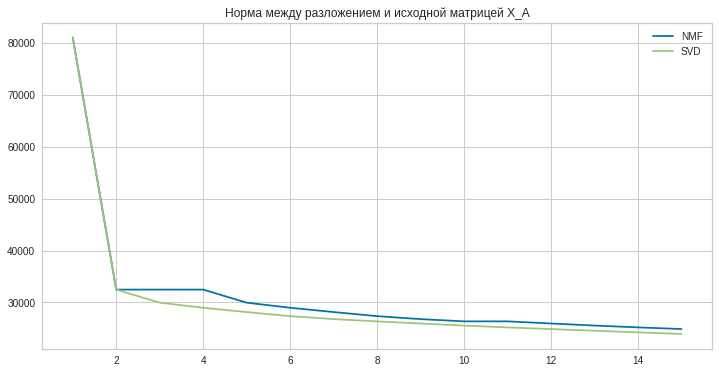

In [43]:
plt.figure(figsize=(12,6))
plt.plot(list(results_nmf.keys()), list(results_nmf.values()), label='NMF')
plt.plot(list(results_svd.keys()), list(results_svd.values()), label='SVD')
plt.legend()
plt.title('Норма между разложением и исходной матрицей X_A')
plt.show()

In [44]:
results_nmf = {}
results_svd = {}
for n_components in tqdm(range(1, 16)):
    model = NMF(n_components=n_components, init='random', random_state=0)
    nmf = model.fit_transform(X_B)
    nmf_em = model.components_
    results_nmf[n_components] = np.linalg.norm(X_B - nmf @ nmf_em)
    
    model = TruncatedSVD(n_components=n_components, random_state=0)
    svd = model.fit_transform(X_B)
    svd_em = model.components_
    results_svd[n_components] = np.linalg.norm(X_B - svd @ svd_em)

 20%|██        | 3/15 [02:12<09:34, 47.89s/it]/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
 47%|████▋     | 7/15 [09:21<12:35, 94.47s/it]/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
 73%|███████▎  | 11/15 [15:41<05:59, 89.76s/it]/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
 80%|████████  | 12/15 [18:26<05:37, 112.50s/it]/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
 87%|████████▋ | 13/15 [21:25<04:

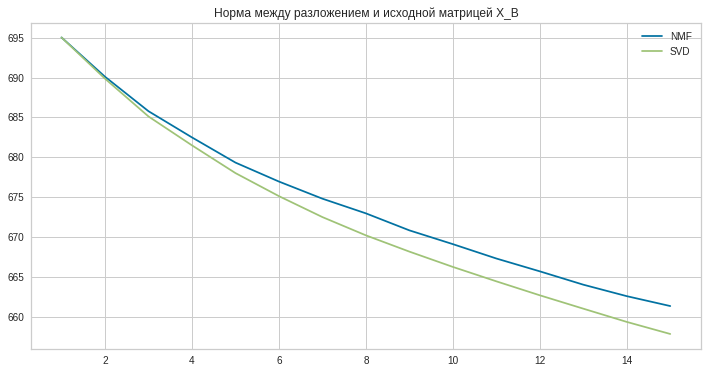

In [46]:
plt.figure(figsize=(12,6))
plt.plot(list(results_nmf.keys()), list(results_nmf.values()), label='NMF')
plt.plot(list(results_svd.keys()), list(results_svd.values()), label='SVD')
plt.legend()
plt.title('Норма между разложением и исходной матрицей X_B')
plt.show()

**Выводы:**  
- "Хорошими" эмбеддингами будем считать те, которые хорошо по L2-норме приближаются к исходной матрице.  
Судя по графику, лучше взять 6-8 компонент, что уже дает хорошее качество, но будет быстрее работать при кластеризации, нежели чем 15.
- SVD лучше, чем NMF, как и следует из теории. 
- Установим разложение SVD на 8 компонент

In [47]:
model = TruncatedSVD(n_components=8, random_state=0)
svd_A = model.fit_transform(X_A)
svd_em_А = model.components_

model = TruncatedSVD(n_components=8, random_state=0)
svd_B = model.fit_transform(X_B)
svd_em_B = model.components_

In [ ]:
svd_A.shape

(20728, 8)

In [ ]:
(svd_A @ svd_em_А).shape

(20728, 3941)

# 4. Кластеризация

## K-MEANS

**Выберем количество кластеров исходя из Elbow Method, базирующийся на расчете WCSS метрики**

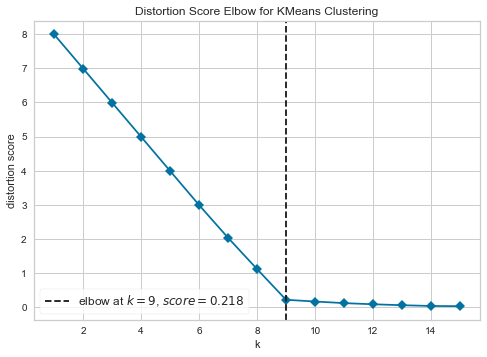

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
# матрица A

from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1, 16), timings= False)
visualizer.fit(svd_em_А.T)
visualizer.show()

Посмотрим, сколько элементов будет в каждом кластере при k=10

In [ ]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(svd_em_А.T)

In [ ]:
Counter(kmeans.labels_)

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(svd_em_А.T)
Counter(kmeans.labels_)

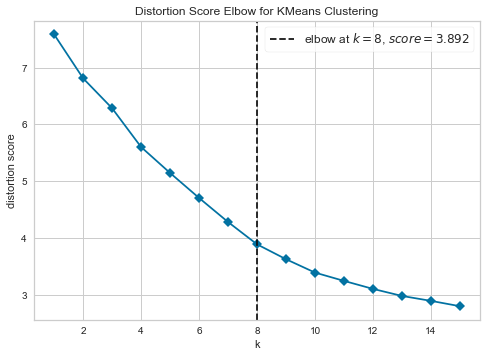

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
# матрица B

model = KMeans()
visualizer = KElbowVisualizer(model, k=(1, 16), timings= False)
visualizer.fit(svd_em_B.T)
visualizer.show()

In [58]:
y_pred = KMeans(n_clusters=10, random_state=0).fit_predict(svd_em_B.T)

In [59]:
X_embedded = TSNE(n_components=2).fit_transform(svd_em_B.T)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [60]:
df = pd.DataFrame()
df["x_component"]=X_embedded[:,0]
df["y_component"]=X_embedded[:,1]
df["labels"] = y_pred

df['StockCode'] = B.columns
df = pd.merge(df, data[['StockCode', 'Description', 'Quantity']], on=['StockCode'], how='left')

In [61]:
fig = px.scatter(df, 
                 x="x_component", 
                 y="y_component", 
                 color = "labels", 
                 size_max=60, hover_data=['Description', 'Quantity'])
fig.update_layout(
     height=800)
fig.show()

In [62]:
figs = []
figs.append(fig)

**Выводы:**  
- Довольно неплохо бейзлайна (как зрительно, так и по функционалу качества) произошла кластеризация матрицы B
- Например, рассмотрим желтый кластер: в нем товары с большим спросом, но также присутствуют и выбросы с маленьким. Я объсняю это разреженностью матрицы и неудачными эмбеддингами.
- Для матрицы А не получается произвести кластеризацию с помощью KMeans, так матрица очень разреженная
- Kmeans не устойчив к выбросам, попробуем DBSCAN

## DBSCAN

In [ ]:
for eps in [1e-10, 1e-8, 1e-6, 1e-5, 1e-4, 1e-3]:
    for min_samples in [3, 5, 10, 20]:
        dbsc = DBSCAN(eps=eps, min_samples=min_samples).fit(svd_em_А.T)
        print(eps, min_samples)
        print(Counter(dbsc.labels_))

1e-10 3
Counter({-1: 3898, 0: 34, 1: 9})
1e-10 5
Counter({-1: 3900, 0: 32, 1: 9})
1e-10 10
Counter({-1: 3909, 0: 32})
1e-10 20
Counter({-1: 3909, 0: 32})
1e-08 3
Counter({-1: 3819, 0: 101, 3: 9, 4: 5, 1: 4, 2: 3})
1e-08 5
Counter({-1: 3826, 0: 101, 1: 9, 2: 5})
1e-08 10
Counter({-1: 3849, 0: 92})
1e-08 20
Counter({-1: 3860, 0: 81})
1e-06 3
Counter({-1: 2730, 0: 1112, 19: 18, 8: 8, 9: 7, 1: 6, 7: 6, 13: 6, 6: 5, 2: 4, 3: 4, 12: 4, 18: 4, 16: 3, 4: 3, 5: 3, 11: 3, 10: 3, 14: 3, 17: 3, 15: 3, 20: 3})
1e-06 5
Counter({-1: 2819, 0: 1048, 6: 18, 2: 17, 1: 13, 7: 9, 5: 6, 3: 6, 4: 5})
1e-06 10
Counter({-1: 2923, 0: 1006, 1: 12})
1e-06 20
Counter({-1: 2981, 0: 960})
1e-05 3
Counter({0: 2197, -1: 1665, 9: 9, 6: 8, 4: 5, 8: 5, 15: 4, 1: 4, 11: 4, 10: 4, 2: 3, 3: 3, 19: 3, 5: 3, 20: 3, 7: 3, 13: 3, 16: 3, 12: 3, 14: 3, 17: 3, 18: 3})
1e-05 5
Counter({0: 2175, -1: 1749, 1: 9, 2: 8})
1e-05 10
Counter({0: 2070, -1: 1843, 1: 19, 2: 9})
1e-05 20
Counter({0: 1981, -1: 1960})
0.0001 3
Counter({0: 3389, 

In [66]:
y_pred = DBSCAN(eps=1e-5, min_samples=5).fit_predict(svd_em_А.T)

In [67]:
X_embedded = TSNE(n_components=2).fit_transform(svd_em_А.T)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [68]:
df = pd.DataFrame()
df["x_component"]=X_embedded[:,0]
df["y_component"]=X_embedded[:,1]
df["labels"] = y_pred
df['StockCode'] = A.columns
df = pd.merge(df, data[['StockCode', 'Description', 'Quantity']], on=['StockCode'], how='left')

In [69]:
fig = px.scatter(df, x="x_component", y="y_component", color = "labels", hover_data=['Description', 'Quantity'], size_max=60)
fig.update_layout(
     height=800)

figs.append(fig)
fig.show()

**Выводы:**  
- HDBSCAN в силу устойчивости к выбросам смог произвести кластеризацию матрицы А
- Хотя опять однако кластеры не очень информативные: два больших и вкрапление маленьких. t-SNE еще, конечно, не передает полностью структуры в проекции
- Кажется, что помимо разложения нужно использовать и другую мета-информации при кластеризации
- Бинарную матрицу с помощью простых эмбеддингов разложить проще, чем с количеством.

# 5. Добавление цены к эмбеддингам

In [71]:
df = pd.DataFrame()
df["x_component"]=X_embedded[:,0]
df["y_component"]=X_embedded[:,1]
df["labels"] = y_pred
df['StockCode'] = A.columns
data_copy = data[['StockCode', 'UnitPrice']]
data_copy.drop_duplicates(subset='StockCode', inplace=True)
df = pd.merge(df, data_copy, on='StockCode', how='left')

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [72]:
svd_em_А_copy = svd_em_А.copy()

In [ ]:
svd_em_А.mean()

0.0004220433605119035

In [74]:
prices = df['UnitPrice'].values
prices.mean()

10.591383151484392

In [75]:
svd_em_А_copy.mean()

0.0004220433605118936

Для того чтобы компонента цены сильно не выбивалась и не имела значительно больший вклад исключительно из-за своей размерности, произведем линейное преобразование и сведем эту компоненту по масштабу к остальным.

In [76]:
svd_em_А_copy = np.vstack([svd_em_А_copy, prices]) / 10**5

# 6. Кластеризация на новых эмбеддингах

In [77]:
y_pred = DBSCAN(eps=1e-6, min_samples=10).fit_predict(svd_em_А_copy.T)

In [78]:
X_embedded = TSNE(n_components=2).fit_transform(svd_em_А.T)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [79]:
df = pd.DataFrame()
df["x_component"]=X_embedded[:,0]
df["y_component"]=X_embedded[:,1]
df["labels"] = y_pred

df['StockCode'] = A.columns
df = pd.merge(df, data[['StockCode', 'Description', 'Quantity']], on=['StockCode'], how='left')

In [80]:
fig = px.scatter(df, x="x_component", y="y_component", color = "labels", hover_data=['Description', 'Quantity'], size_max=60)
fig.update_layout(
     height=800)

figs.append(fig)
fig.show()

**Выводы:**   
- Добавление фичи цены в эмбеддинг повышает качество кластеризации
- Цена позволяет строить лучше эмбеддинг в том смысле, что разделение поверхности происходит четче.

# 7. Товары-заменители

Товары-заменители в пространстве эмбеддингов будут лежать рядом.   
Построим иерархическую кластеризацию и посмотрим на внутренние уровни.

In [ ]:
df = pd.DataFrame()
df['StockCode'] = A.columns
df = pd.merge(df, data[['StockCode', 'Description', 'Quantity']], on=['StockCode'], how='left')
df = df.drop_duplicates(subset=['StockCode'])
names = dict(zip(df.StockCode, df.Description))
df = df.rename(columns=names)

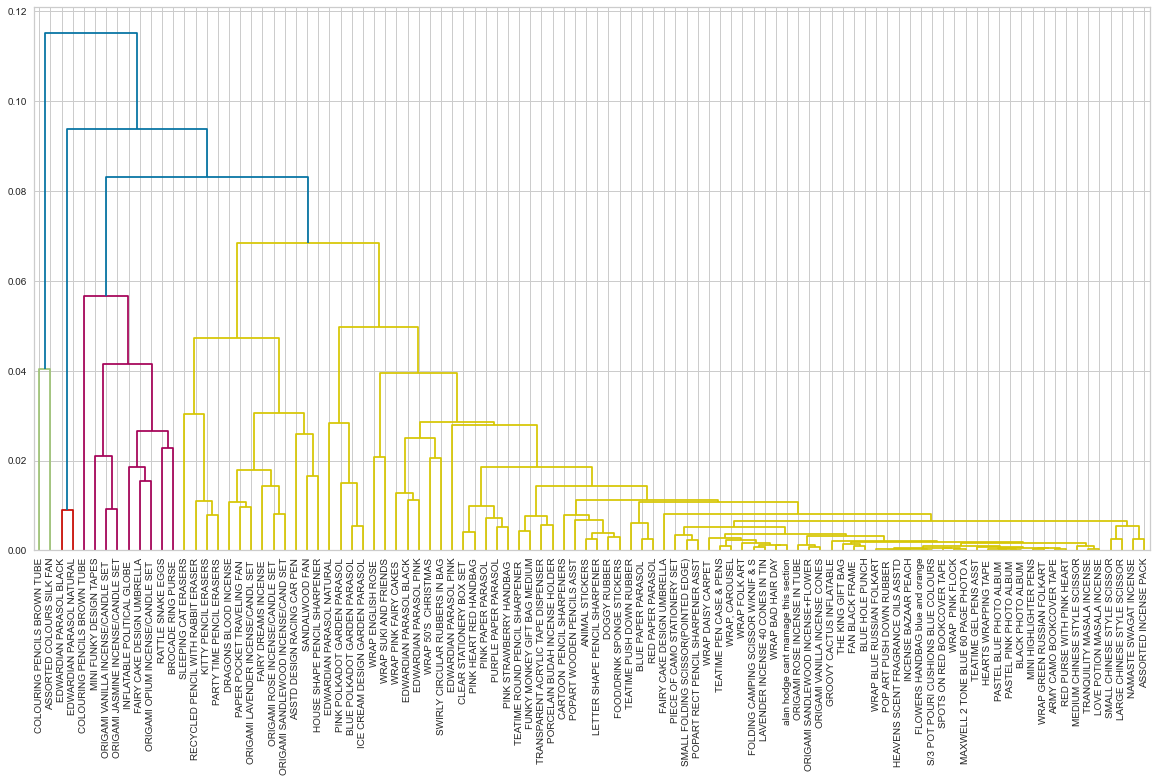

In [ ]:
mergings = linkage(svd_em_B.T[:100,:], method='complete')
varieties = df.columns[:100]

plt.figure(figsize=(20, 10))
dendrogram(mergings,
           labels=varieties,
           leaf_rotation=90,
           leaf_font_size=10,
          );

**Посмротрим на кластеры:**  
- Оригами, карандаши разных видов, сумки выделились в один кластер
- Товары на нижних уровнях дендогаммы можно считать товарами-заменителями

# 8. Товары-якоря

Построим матрицу совстречаемости товаров

Чтобы ускорить процесс построения, отфильтруем чеки, в которых меньше 3-х товаров и больше, чем 95-квантиль.

In [6]:
df_result = {}
lens = []
for number in tqdm(data['InvoiceNo'].unique()):
  data_temp = data[data['InvoiceNo'] == number]
  df_result[number] = data_temp['StockCode'].values.tolist()
  lens.append(len(df_result[number]))

100%|██████████| 20728/20728 [12:25<00:00, 27.81it/s]


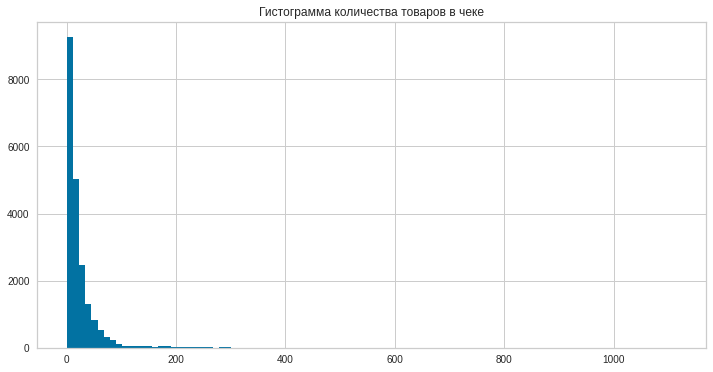

In [7]:
plt.figure(figsize=(12,6))
plt.hist(lens, bins=100)
plt.title('Гистограмма количества товаров в чеке')
plt.show()

In [8]:
df_matrix = pd.DataFrame(0, columns = data['StockCode'].unique(), index = data['StockCode'].unique())

In [9]:
quntile_095 = pd.Series(lens).quantile(0.95)

In [10]:
for number in tqdm(df_result.keys()):
  if len(df_result[number]) >= 3 and len(df_result[number]) <= quntile_095:
    for pair in list(itertools.combinations(df_result[number], 2)):
      df_matrix.loc[pair[0], pair[1]] += 1
      df_matrix.loc[pair[1], pair[0]] += 1

100%|██████████| 20728/20728 [33:57<00:00, 10.18it/s]


In [11]:
df_matrix.head()

,85123A,71053,84406B,84029G,84029E,22752,21730,22633,22632,84879,...,23560,23576,23562,23561,23609,85179a,23617,90214U,47591b,23843
85123A,102,75,75,67,56,48,49,63,38,253,...,0,3,0,0,0,0,0,0,0,0
71053,75,32,27,22,20,20,20,3,0,23,...,0,0,0,0,0,0,0,0,0,0
84406B,75,27,6,22,20,23,18,8,4,29,...,0,0,0,0,0,0,0,0,0,0
84029G,67,22,22,12,96,19,19,53,25,15,...,0,1,0,0,0,0,0,0,0,0
84029E,56,20,20,96,16,24,19,41,36,24,...,0,2,0,0,0,0,0,0,0,0


**Посмотрим на несколько кластеров:**

In [26]:
data[data.StockCode == '85123A']['Description'].unique()[0]

'WHITE HANGING HEART T-LIGHT HOLDER'

In [27]:
for name in df_matrix.iloc[0, :].nlargest(5).index.tolist():
  print(data[data.StockCode == name]['Description'].unique()[0])

RED HANGING HEART T-LIGHT HOLDER
WOODEN PICTURE FRAME WHITE FINISH
CANDLEHOLDER PINK HANGING HEART
HEART OF WICKER LARGE
ASSORTED COLOUR BIRD ORNAMENT


Частотные совместные покупки с 

-------

ВЯЗАНАЯ ГРЕЛКА С ФЛАГОМ СОЮЗА:

-------

ШОКОЛАДНАЯ ГРЕЛКА

РЫЖАЯ ШЕРСТИСТАЯ КРАСОТКА С БЕЛЫМ СЕРДЦЕМ

ГРЕЛКА СОХРАНЯЙТЕ СПОКОЙСТВИЕ

БУТЫЛКА С ГОРЯЧЕЙ ВОДОЙ ДЛЯ СКОТТИ ДОГА

БЕЛАЯ ГРЕЛКА С ЧЕРЕПОМ

------------
------------


БЕЛЫЙ ПОДВЕСНОЙ СЕРДЕЧНЫЙ Т-ОБРАЗНЫЙ ДЕРЖАТЕЛЬ:

--------

КРАСНЫЙ ПОДВЕСНОЙ СЕРДЕЧНЫЙ Т-ОБРАЗНЫЙ ДЕРЖАТЕЛЬ

ДЕРЕВЯННАЯ РАМКА ДЛЯ ФОТОГРАФИЙ С БЕЛОЙ ОТДЕЛКОЙ

ПОДСВЕЧНИК РОЗОВОЕ ПОДВЕСНОЕ СЕРДЦЕ

СЕРДЦЕ ИЗ ПЛЕТЕНОГО БОЛЬШОГО

РАЗНОЦВЕТНЫЙ ПТИЧИЙ ОРНАМЕНТ



**Выводы:**   
- Кажется, что в целом для простого бейзлайна получается неплохо:действительно, вместе товаром: подвестной держатель, который можно расценивать как якорь, покупают вместе сердце, рамку и разную другую утварь для дома в комплект по стилю

- В кластерах товаров-якорей прослеживаются и заменители. 
Например, в первом с грелками. Это может получится из-за того, что порою покупают несколько видом одного товара для разнообразия, если надо несколько штук. Таким образом, возникает смешение кластеров.

**Общие выводы:**   
- Была произведена кластеризация товаров на основе эмбеддингов, полученных в ходе матричных разложений.
- Матрица получается разреженной (что типично в таких задачах), что мешает получить хорошие разделяющие поверхности:(
- Добавление цены в эмбеддинг повышает качество, так как эмбеддинги получаются более "информативными"
- Основной проблемой применения данного подхода в динамическом ценообразовании, на мой взгляд, является разреженность матрицы, из-за прямой подход с матричными разложениями не дает хорошего качества. Возможно, качественный препроцессинг, нормализация помогут достичь значительно прироста.

- Выводы по отдельным пунктам приложены после них

In [83]:
with open('plots.html', 'a') as f:
  for fig in figs:
    f.write(fig.to_html(full_html=False, include_plotlyjs='cdn'))